## Process Optimization - the `Main` code 

### First Batch of Bayesian Optimization based on Experimental Data produced on Sep 22, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [1]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Load the experimental film data

In [2]:
########## Read in excel file ##########

# df_film = pd.read_excel('/Users/matt/Desktop/RAPID optimization/SL-PerovskiteOpt/ML_perovskite_data.xlsx', sheet_name='PVK Data')
df_film = pd.read_excel(
    "/groups/aprintz/github/SL-PerovskiteOpt/Binary_Classification_BO/Capillary action/241112_Capillary_ML_perovskite_data.xlsx", #can copy and paste the file path directly here
    sheet_name="PVK Data",
)

df_film.columns = [ #need to update this to only have what we have in our excel sheet
    "ML Condition",
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "volume used [uL]",
    "Confinement gap [um]",
    "% DMSO",
    "CB Additive",
    "Success or Fail",
    "Notes",
]
########## Get successful processing conditions ##########

success_conditions = df_film[df_film["Success or Fail"] == 1]["ML Condition"].values

########## Define processing variables to include ##########

included_vars = [
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "% DMSO",
    "CB Additive"
]

########## Define new dataframe with only included processing variables ##########

df_included_vars = df_film[included_vars]
df_included_vars



,Molarity [M],Temperature [°C],Speed [m/min],% DMSO,CB Additive
0,0.30,100,1,10,0
1,0.30,100,10,10,0
2,0.30,100,20,10,0
3,0.30,100,40,10,0
4,0.30,100,60,10,0
...,...,...,...,...,...
115,0.35,50,70,20,0
116,0.35,50,60,20,4
117,0.35,50,70,20,4
118,0.30,50,60,20,4


# Set the variable space of process conditions

In [3]:
import numpy as np

precursor_min, precursor_max, precursor_step = [0.3, 0.6, 0.5]  # Unit: concentration
precursor_var = np.arange(precursor_min, precursor_max + precursor_step, precursor_step)
precursor_num = len(precursor_var)

super_temp_min, super_temp_max, super_temp_step = [50, 100, 25]  ## Unit: degC
super_temp_var = np.arange(super_temp_min, super_temp_max + super_temp_step, super_temp_step)
super_temp_num = len(super_temp_var)

speed_min, speed_max, speed_step = [1, 80, 10]  ## Unit: m/min
speed_var = np.arange(speed_min, speed_max + speed_step, speed_step)
speed_num = len(speed_var)

# dist_min, dist_max, dist_step = [25, 200, 25]  ## Unit: microns
# dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
# dist_num = len(dist_var)

dmso_min, dmso_max, dmso_step = [0, 40, 10]  # Unit: %DMSO
dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
dmso_num = len(dmso_var)

# sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 25]  ## Unit: degC
# sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
# sub_temp_num = len(sub_temp_var)

CB_min, CB_max, CB_step = [0, 10, 2.5]  ## Unit: Minutes
CB_var = np.arange(CB_min, CB_max + CB_step, CB_step)
CB_num = len(CB_var)

# anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes
# anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
# anneal_num = len(anneal_var)

########## Create process variable array ##########
var_array = [
    precursor_var,
    super_temp_var,
    speed_var,
    dmso_var,
    CB_var
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Precursor Concentration [M]",
    "Superstrate Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "DMSO Concentration [%v/v]",
    "CB additive [%w/PbI2]"
]

print(var_array)

[array([0.3, 0.8]), array([ 50,  75, 100]), array([ 1, 11, 21, 31, 41, 51, 61, 71, 81]), array([ 0, 10, 20, 30, 40]), array([ 0. ,  2.5,  5. ,  7.5, 10. ])]


### Define Emukit variable space from above processing conditions. Only edit if variables added/removed. Make sure the order and number of variables is consistent!

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter

parameter_space = ParameterSpace([ContinuousParameter('Precursor', 0, 1),
                                 ContinuousParameter('SuperTemp', 0, 1),
                                 ContinuousParameter('Speed', 0, 1),
                                #  ContinuousParameter('Dist', 0, 1),
                                 ContinuousParameter('DMSO', 0, 1),
                                 ContinuousParameter('CB', 0, 1),
                                #  ContinuousParameter('Anneal', 0, 1),
                                 ])

def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

### Run GP Classification on the Experimental Data using GPy
- Experimental film data for round 0 initial sampling: binary film quality

### https://gpy.readthedocs.io/en/deploy/GPy.models.html#module-GPy.models.gp_classification
### https://notebook.community/SheffieldML/notebook/GPy/basic_classification

In [5]:
from emukit.core.interfaces import IModel
from typing import Tuple

x_init = x_normalizer(df_included_vars.to_numpy()) # Normalize experimental data
y_init = np.transpose([df_film["Success or Fail"].to_numpy()]) # Get array of pass/fail conditions
X, Y = [x_init, y_init] # Rename variables to statistics standard

input_dim = len(X[0])  # Get number of variables in data

class GPClassModel(IModel):
    def __init__(self, GPClassifierModel: GPy.core.Model, n_restarts: int = 1, max_iters: int = 1000):
        self.model = GPClassifierModel
        self.n_restarts = n_restarts
        self.max_iters = max_iters

    def predict(self, X, include_likelihood: bool = False): # need to edit this
        return self.model.predict_noiseless(X) # latent function only
        # return self.model.predict(X, include_likelihood=include_likelihood, ) # latent function only

    def get_prediction_gradients(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        :param X: (n_points x n_dimensions) array containing locations at which to get gradient of the predictions
        :return: (mean gradient, variance gradient) n_points x n_dimensions arrays of the gradients of the predictive
                 distribution at each input location
        """
        d_mean_dx, d_variance_dx = self.model.predictive_gradients(X)
        return d_mean_dx[:, :, 0], d_variance_dx

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.set_XY(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        self.model.optimize_restarts(self.n_restarts, max_iters=self.max_iters, verbose=verbose, robust=True)

    @property
    def X(self) -> np.ndarray:
        return self.model.X

    @property
    def Y(self) -> np.ndarray:
        return self.model.Y

reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale



Name : gp_classification
Objective : 21.92161337973589
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  Mat52.variance      |   10.0  |   1.0,10.0    |        
  Mat52.lengthscale   |   (5,)  |   0.1,100.0   |        
[10.          0.11434048 99.99999952  0.32208718 99.99999477  1.22914817]
100.0 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  48.0      |  0         | 
0         |  0         |  72.0      | 
all rmse: 0.0000
all R^2: 1.0000
all spearman: 1.0000


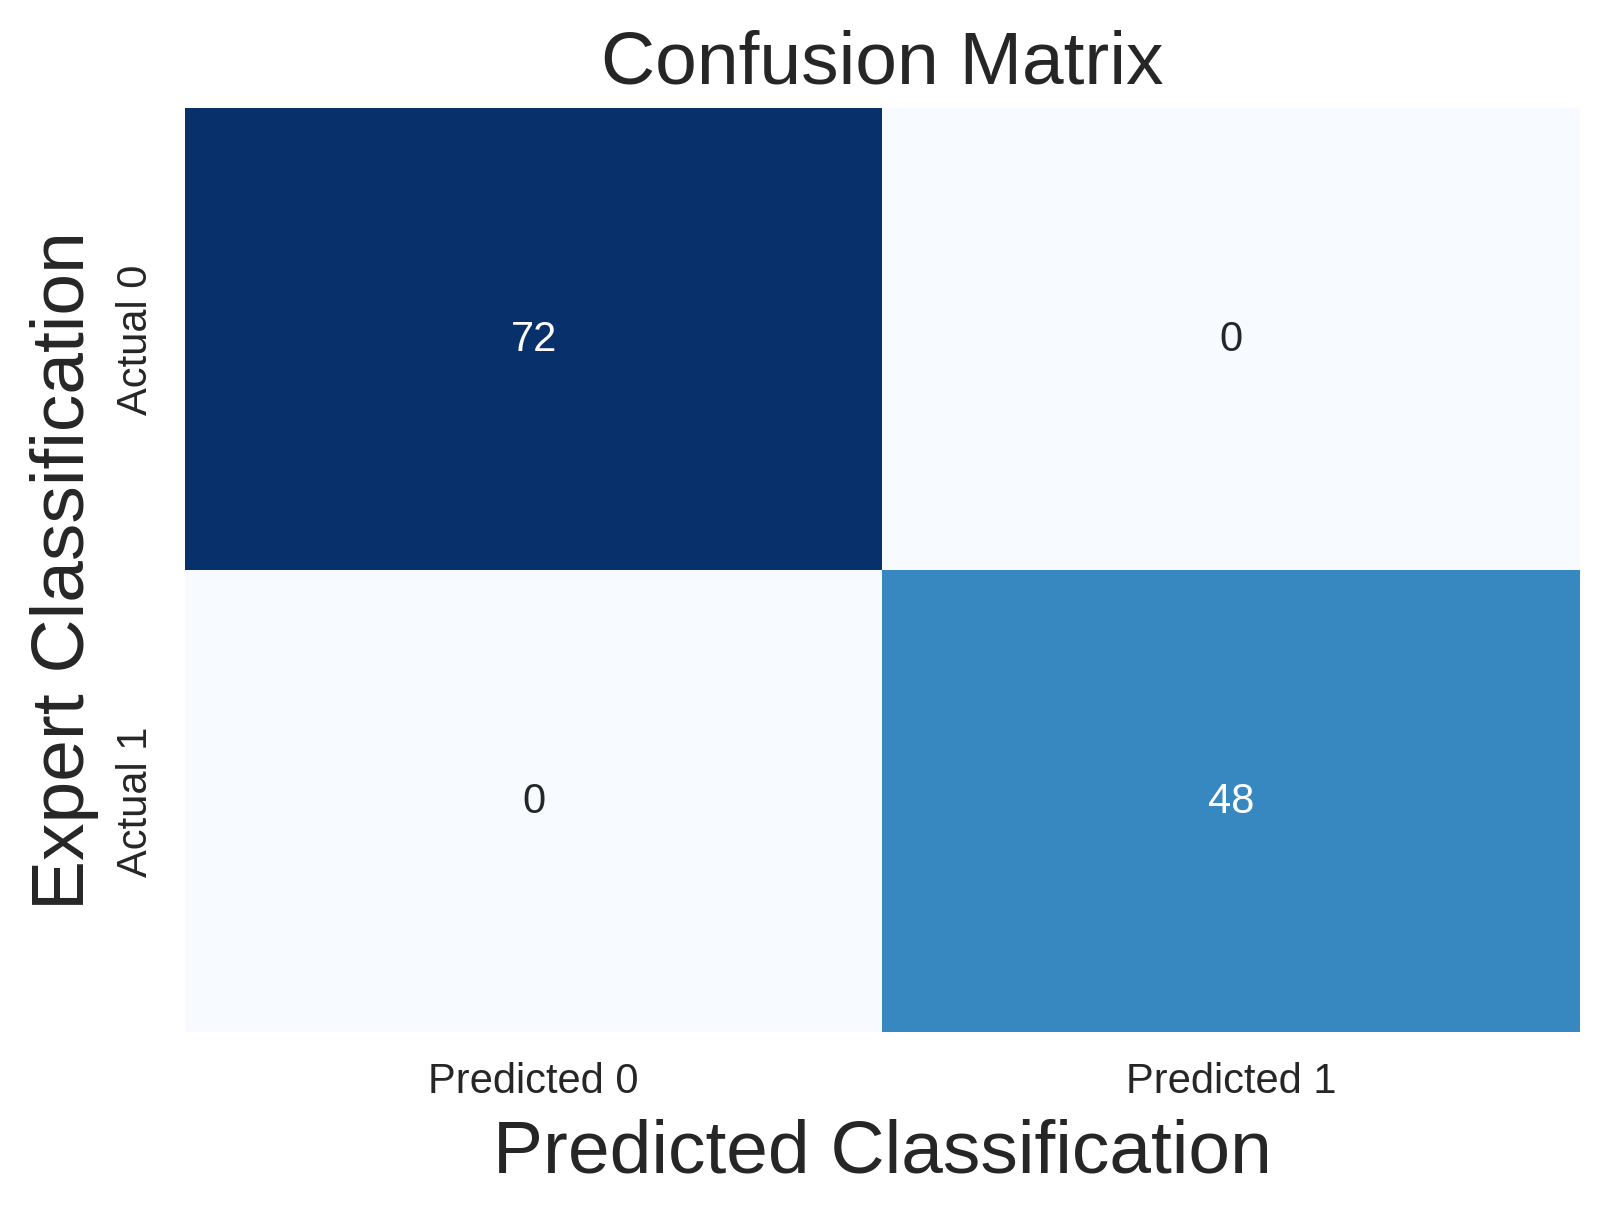

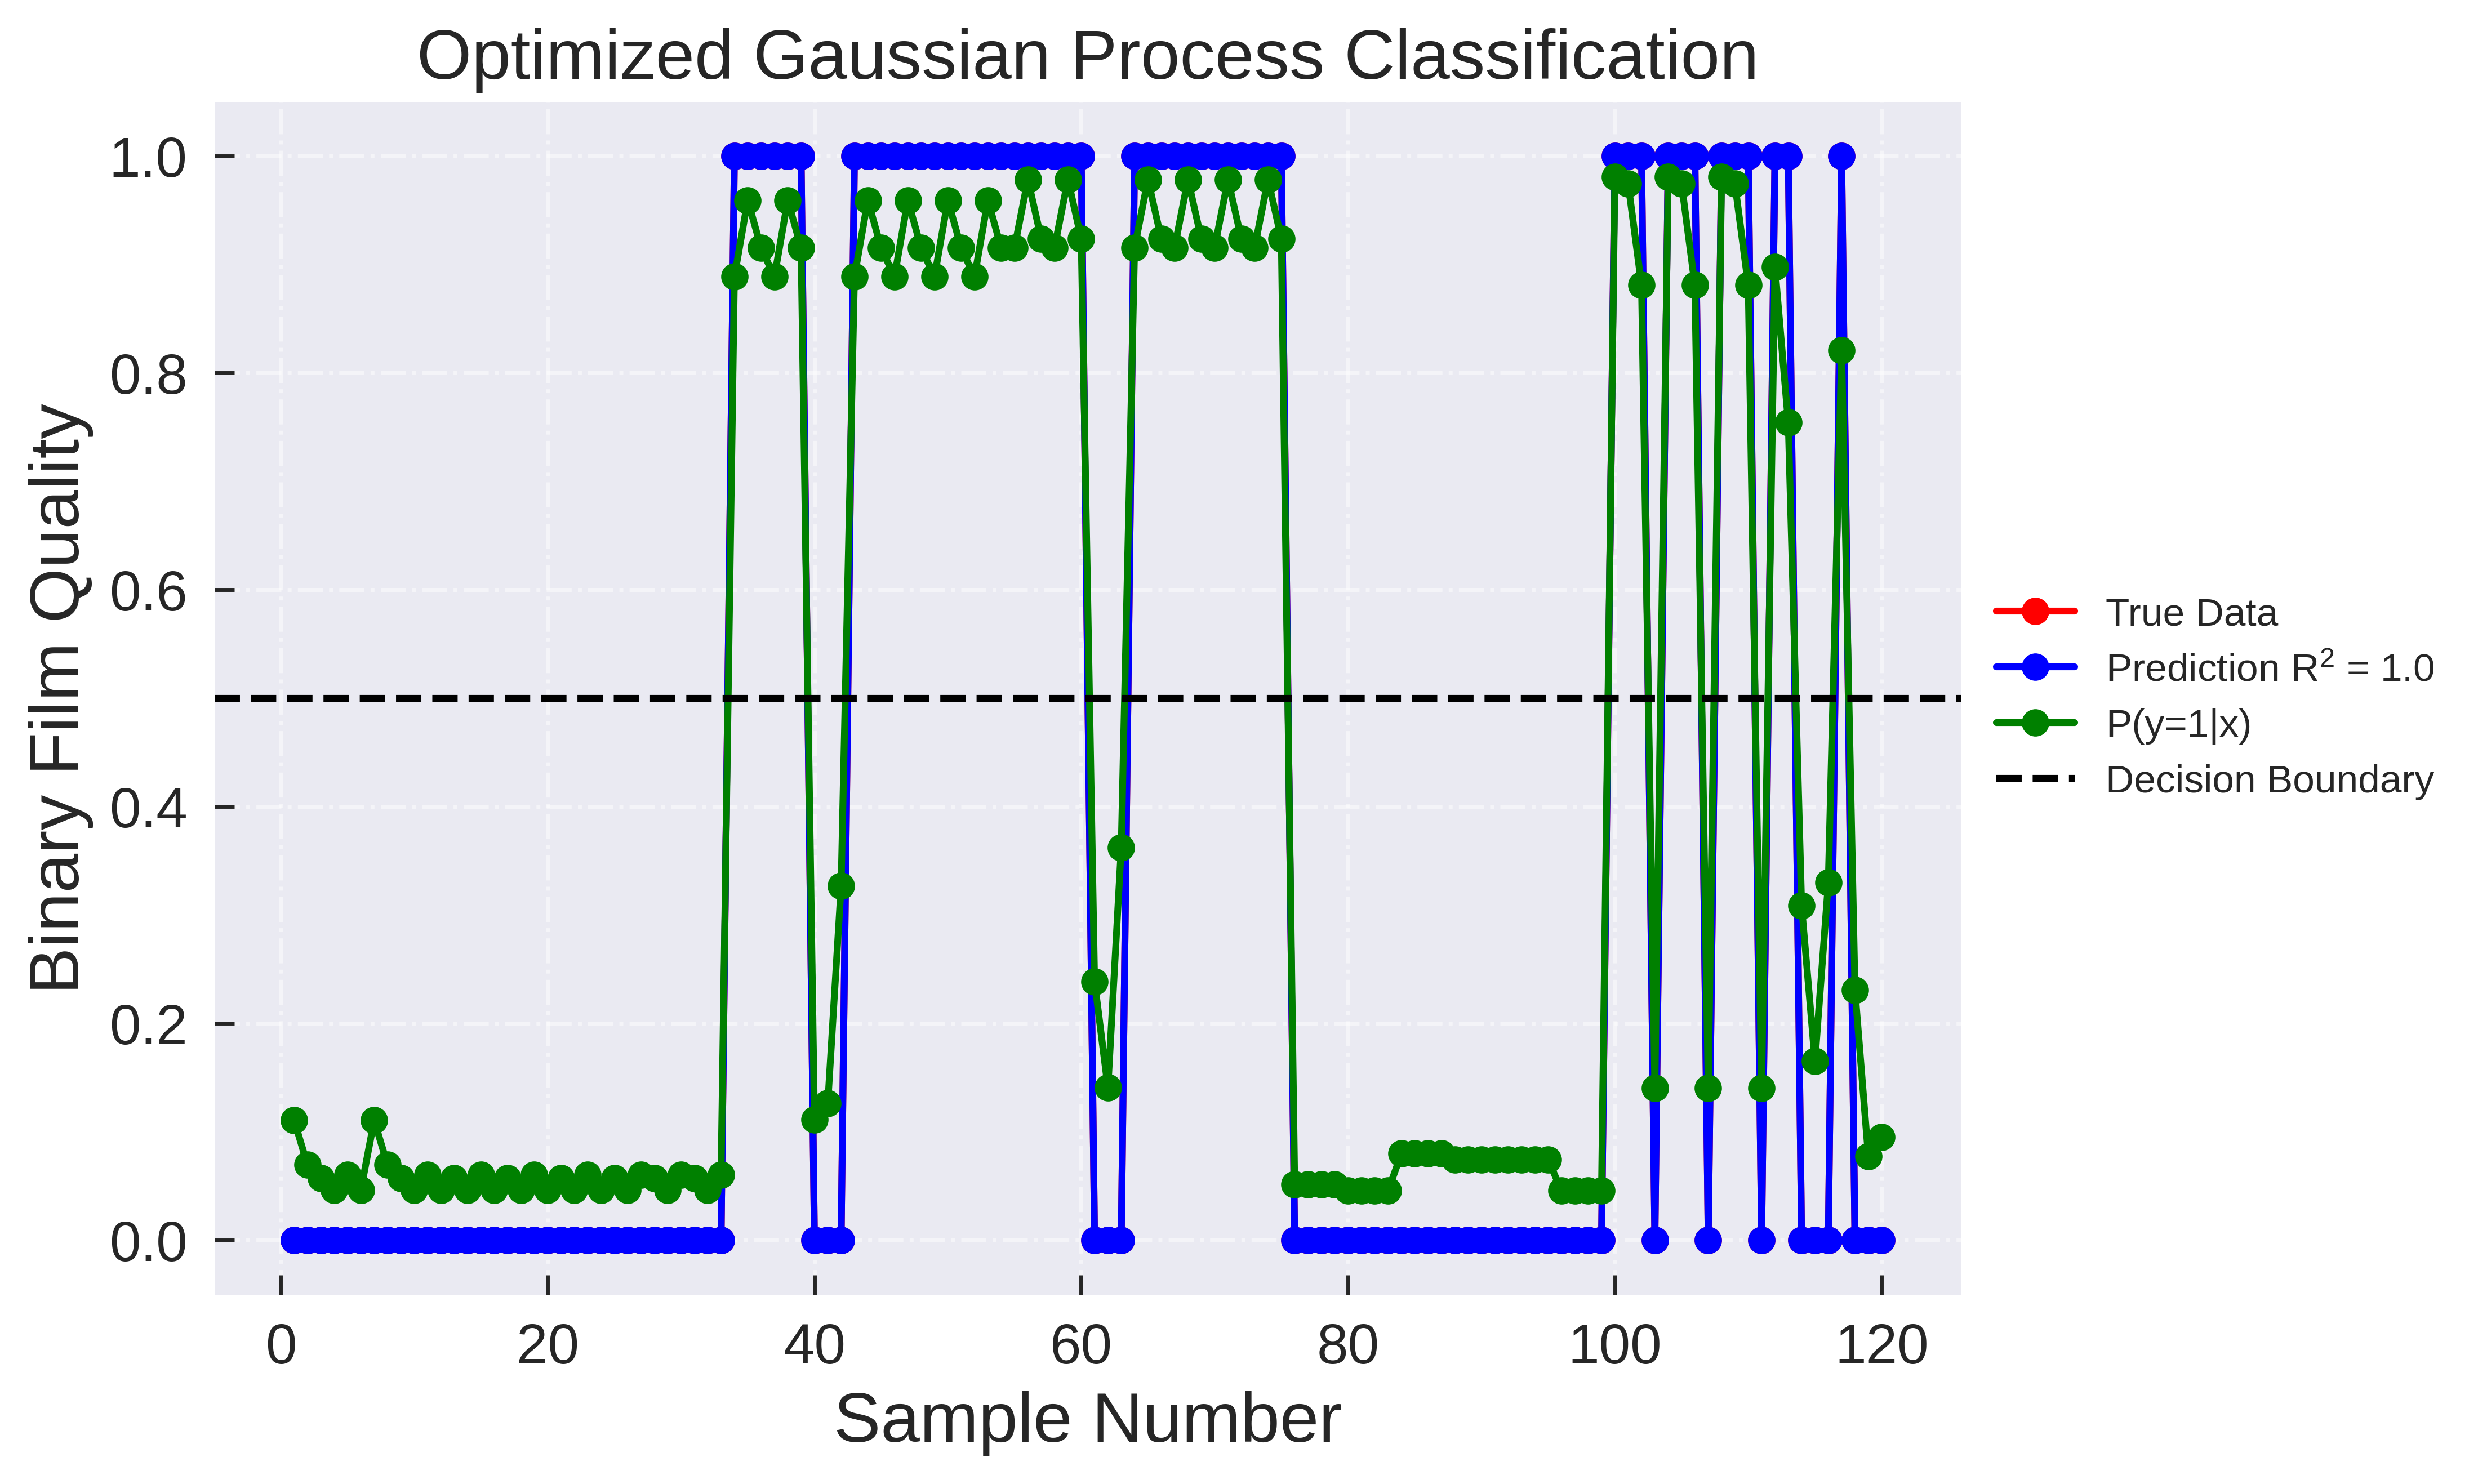

In [18]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import style
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from scipy.stats import spearmanr
# from GPy.likelihoods.link_functions import Logistic
np.random.seed(10)  # Seed for reproducible randomization



style.use('default') # Complete reset the matplotlib figure style
style.use('seaborn') # use one of the existing matplotlib style sheet ## I also changed this from 'seaborn-v0_8-ticks' since this style isnt available anymore

lik = GPy.likelihoods.Bernoulli(
    # gp_link=Logistic
    ) # set Bernoulli likelihood for posterior
# inf = GPy.inference.latent_function_inference.expectation_propagation.EP()
inf = GPy.inference.latent_function_inference.Laplace()

kernel = GPy.kern.Matern52(
    input_dim=input_dim,
    ARD=True
)

# kernel = GPy.kern.RBF(
#     input_dim=input_dim,
#     ARD=True
# )

var_low = 1
var_high = 10
l_low = 1e-1
l_high = 1e2

# Set optimization parameters
kernel.variance.constrain_bounded(var_low, var_high)
kernel.lengthscale.constrain_bounded(l_low, l_high)

# Create the GP classifier with the best hyperparameters
model_gpy = GPy.models.GPClassification(X, Y,
                                        kernel=kernel,
                                        likelihood=lik,
                                        inference_method=inf
                                        )

model_gpy.randomize()

objective_model = GPClassModel(model_gpy)
# objective_model.set_data(X, Y)
objective_model.n_restarts = 100
objective_model.max_iters = 1000
objective_model.optimize()

#https://gpy.readthedocs.io/en/deploy/_modules/GPy/core/gp.html#GP.predict

mu_f, var_f = objective_model.predict(X) # predict latent function values
p = lik.gp_link.transf(mu_f / np.sqrt(1 + var_f)) # squash the latent function to give probability p(y=1|x,D)

# prob0, prob1 = compute_proba(f_mu, f_var)
# print(prob1)

# Convert probabilities to binary predictions since model outputs contineous data in the space [0,1]
threshold = 0.5  # Above threshold, pass. Below threshold, fail.
y_pred_binary = (p > threshold).astype(int)

print(objective_model.model)
print(objective_model.model.param_array)
GPy.util.classification.conf_matrix(y_pred_binary, Y)

fontsize = 18
lims = (-0.1, 1.1)

mse = mean_squared_error
mse_all = mse(Y, y_pred_binary)
print("all rmse: %.4f" % (np.sqrt(mse_all)))

rsquared_all = r2_score(Y, y_pred_binary)
print("all R^2: %.4f" % (rsquared_all))

sprman_all = spearmanr(Y, y_pred_binary)
print("all spearman: %.4f" % (sprman_all[0]))

# Create confusion matrix
cm = confusion_matrix(y_pred_binary, Y)

# Create a Seaborn heatmap
plt.figure(figsize=(6, 4), dpi=300)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel("Predicted Classification", fontsize=fontsize)
plt.ylabel("Expert Classification", fontsize=fontsize)
plt.title("Confusion Matrix", fontsize=fontsize)
plt.show()

# Plot the true input data and the prediction against the data point number
plt.figure(dpi=500)
sample_array = np.array(range(1, len(Y) + 1))
plt.plot(range(1, len(Y) + 1), Y, "ro-", label="True Data")
plt.plot(range(1, len(Y) + 1), y_pred_binary, "bo-", label=r"Prediction $\mathregular{R^{2}}$ = " + f"{round(rsquared_all, 3)}")
plt.plot(range(1, len(Y) + 1), p, "go-", label="P(y=1|x)")
plt.axhline(y=0.5, c='black', linestyle='dashed', label="Decision Boundary")

title = "Optimized Gaussian Process Classification"
plt.xlabel("Sample Number", fontsize=fontsize)
plt.ylabel("Binary Film Quality", fontsize=fontsize)
plt.title(title, fontsize=fontsize)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.tick_params(
    direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
)
plt.grid(True, linestyle="-.")




In [7]:
# print(objective_model.X)
# print(f_mu)

# Bayesian Optimization 

### Define UCB_phi a la "Efficient exploration in binary and preferential Bayesian optimization"

In [8]:
from typing import Tuple, Union
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IDifferentiable, IModel
from scipy.special import owens_t

class NegativeLowerConfidenceBound_Phi(Acquisition):
    def __init__(self, model: Union[IModel, IDifferentiable], beta: float = 1.0) -> None:
        """
        This acquisition computes the negative lower confidence bound for a given input point. This is the same
        as optimizing the upper confidence bound if we would maximize instead of minimizing the objective function.
        For information as well as some theoretical insights see:

        Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design
        Niranjan Srinivas, Andreas Krause, Sham Kakade, Matthias Seeger
        In Proceedings of the 27th International Conference  on  Machine  Learning

        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param beta: Is multiplied on the standard deviation to control exploration / exploitation
        """
        self.model = model
        self.beta = beta

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the negative lower confidence bound

        :param x: points where the acquisition is evaluated.
        """
        mu_f, var_f = self.model.predict(x)

        h = mu_f / np.sqrt(1 + var_f)
        a = 1.0 / np.sqrt(1 + 2*var_f)
        E = GPy.likelihoods.Bernoulli().gp_link.transf(h)
        V = E - 2*owens_t(h, a) - E**2

        return -(E - self.beta * np.sqrt(V)) # first negative sign because we minimize, not maximize with emukit. second negative sign because "lower confidence bound" instead of upper

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the negative lower confidence bound and its derivative

        :param x: points where the acquisition is evaluated.
        """
        mu_f, var_f = self.model.predict(x)
        std_dev_f = np.sqrt(var_f)
        dmu_f_dx, dvar_f_dx = self.model.get_prediction_gradients(x)
        dstd_dev_f_dx = dvar_f_dx / (2 * std_dev_f)

        h = mu_f / np.sqrt(1 + var_f)
        a = 1.0 / np.sqrt(1 + 2*var_f)

        E = GPy.likelihoods.Bernoulli().gp_link.transf(h)
        V = E - 2*owens_t(h, a) - E**2
        lcb_phi = -(E - self.beta * np.sqrt(V))

        dh_dx = (np.sqrt(1+var_f)*dmu_f_dx - mu_f*(1/np.sqrt(1+var_f))*std_dev_f*dstd_dev_f_dx)/(1+var_f)
        da_dx = (-2*(1+2*var_f) ** (-3/2)) * std_dev_f* dstd_dev_f_dx

        dT_dh = -np.exp(-(h**2)/2)/np.sqrt(2*np.pi) * (GPy.likelihoods.Bernoulli().gp_link.transf(h*a) - (1/2))
        dT_da = (1/(2*np.pi)) * np.exp(-((h**2)/2) * (1 + a**2)) / (1 + a**2)

        dE_dx = GPy.likelihoods.Bernoulli().gp_link.dtransf_df(h) * dh_dx
        dsqrtV_dx = (dE_dx - 2*(dT_dh*dh_dx + dT_da*da_dx) - 2*E*dE_dx) / (2*np.sqrt(V))

        dlcb_dx = -(dE_dx - self.beta * dsqrtV_dx)

        return lcb_phi, dlcb_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

### Use Emukit to perform bayesian optimization on GPy model and extract new test conditions
https://nbviewer.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_external_objective_evaluation.ipynb


In [11]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound

# # acquisition_function = ExpectedImprovement(model=objective_model)
# lik = GPy.likelihoods.Bernoulli() # set Bernoulli likelihood for posterior

# # inf = GPy.inference.latent_function_inference.expectation_propagation.EP() #doesnt work with batch size >= 1
# inf = GPy.inference.latent_function_inference.Laplace()

# kernel = GPy.kern.Matern52(
#     input_dim=input_dim,
#     ARD=True
# )

# # Set optimization parameters
# kernel.variance.constrain_bounded(var_low, var_high)
# kernel.lengthscale.constrain_bounded(l_low, l_high)

# # Create the GP classifier with the best hyperparameters
# model_gpy = GPy.models.GPClassification(X, Y,
#                                         kernel=kernel,
#                                         likelihood=lik,
#                                         inference_method=inf
#                                         )

# model_gpy.randomize()
# objective_model = GPClassModel(model_gpy)
# objective_model.set_data(X, Y)
# objective_model.n_restarts = 100
# objective_model.max_iters = 1000
# objective_model.optimize()


In [12]:

# acquisition_function = NegativeLowerConfidenceBound(model=objective_model, beta=2) #since emukit minimizes, this is the same as UCBf of the latent function f

beta = 1
acquisition_function = NegativeLowerConfidenceBound_Phi(model=objective_model, beta=beta)
num_new_samples = 10
num_iterations = 1

expdesign_loop = ExperimentalDesignLoop(
    model=objective_model,
    space=parameter_space,
    acquisition=acquisition_function,
    batch_size=num_new_samples,
    update_interval=1,
)

# for _ in range(num_iterations):
X_new = expdesign_loop.get_next_points(None)
    # print(X_new)

X_new = get_closest_array(x_denormalizer(X_new)) # make sure variable array is correct!
x_new_norm = x_normalizer(X_new)


# df_X_new = pd.DataFrame(X_new, columns=x_labels).sort_values(by='Working Distance [μm]')
df_X_new = pd.DataFrame(X_new, columns=x_labels).drop_duplicates()
df_X_new


,Precursor Concentration [M],Superstrate Temperature [°C],Speed [m/min],DMSO Concentration [%v/v],CB additive [%w/PbI2]
0,0.3,75.0,81.0,0.0,7.5
1,0.3,75.0,81.0,0.0,10.0
2,0.3,100.0,81.0,30.0,0.0
3,0.3,50.0,81.0,30.0,10.0
4,0.8,75.0,21.0,20.0,5.0
5,0.8,75.0,21.0,40.0,0.0
6,0.8,50.0,21.0,0.0,5.0
7,0.8,75.0,21.0,0.0,7.5
8,0.8,50.0,21.0,20.0,0.0
9,0.8,75.0,21.0,40.0,7.5


#### Quick histogram visualization of the newly suggested process conditions

#### Visualisation of Efficiency vs ML conditions, and Acquisition

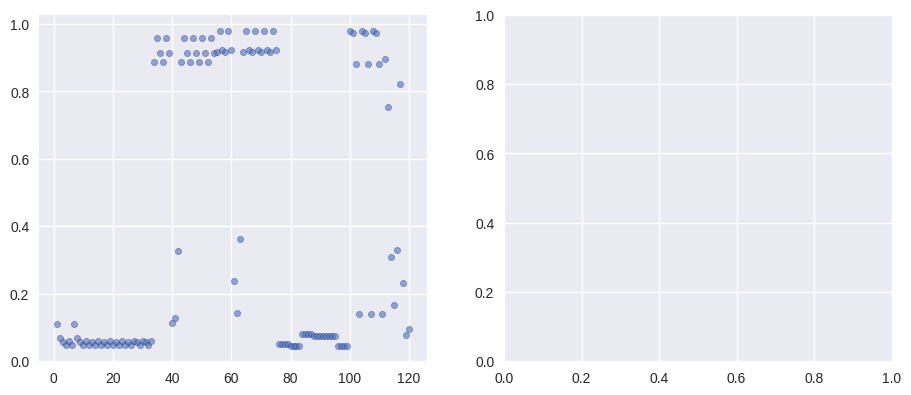

In [13]:
film_quality = df_film.sort_values('ML Condition')["Success or Fail"].values
ml_cond = df_film.sort_values('ML Condition')["ML Condition"].values
X_sorted = x_normalizer(df_included_vars.values)

f_mu, f_var = objective_model.predict(X_sorted)

p_success = GPy.likelihoods.Bernoulli().gp_link.transf(f_mu / np.sqrt(1 + f_var))

# y_pred = -y_pred[:, -1]
# y_uncer = np.sqrt(y_uncer[:, -1])

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=False)
fontsize = 20
axes[0].scatter(
    ml_cond,
    p_success,  # facecolor = 'none',
    edgecolor="navy",
    s=20,
    alpha=0.6,
    label="experiment",
)


### Visualize the Manifold of the Trained Models

##### Device Efficiency based on IV Measurement Data (after Pre-screened by Visual Inspection)
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

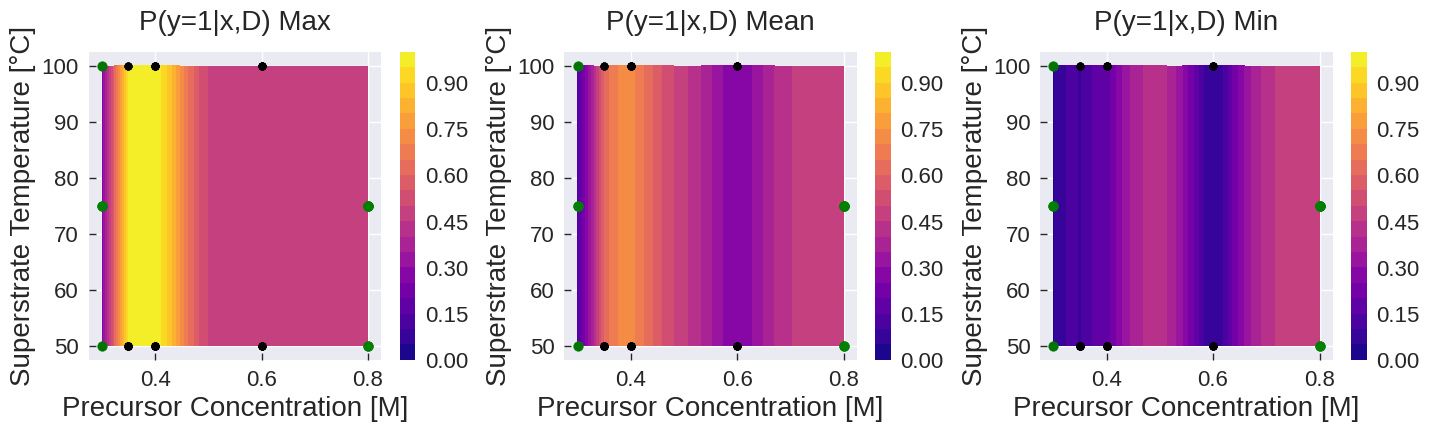

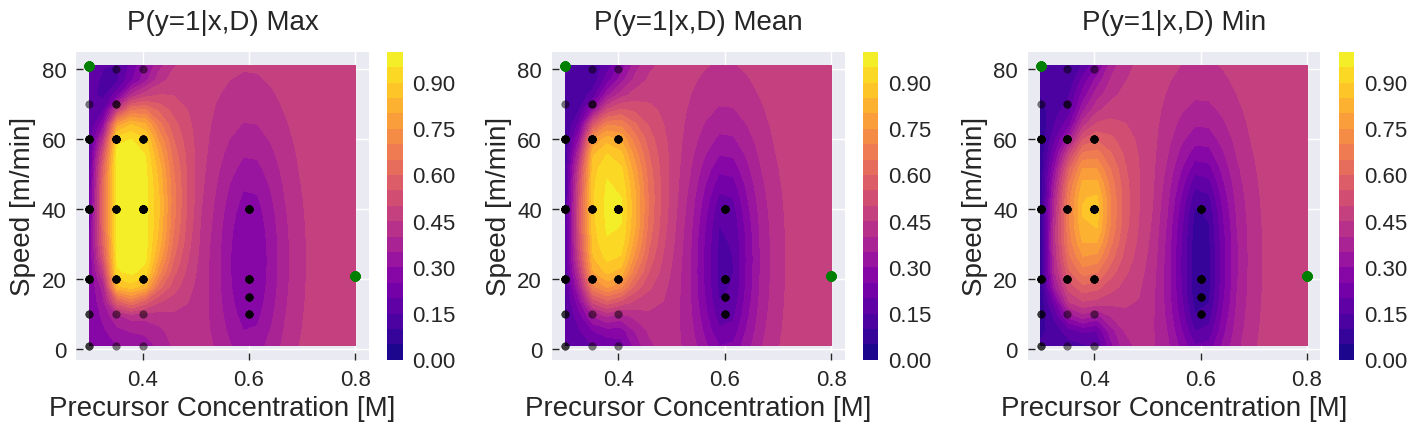

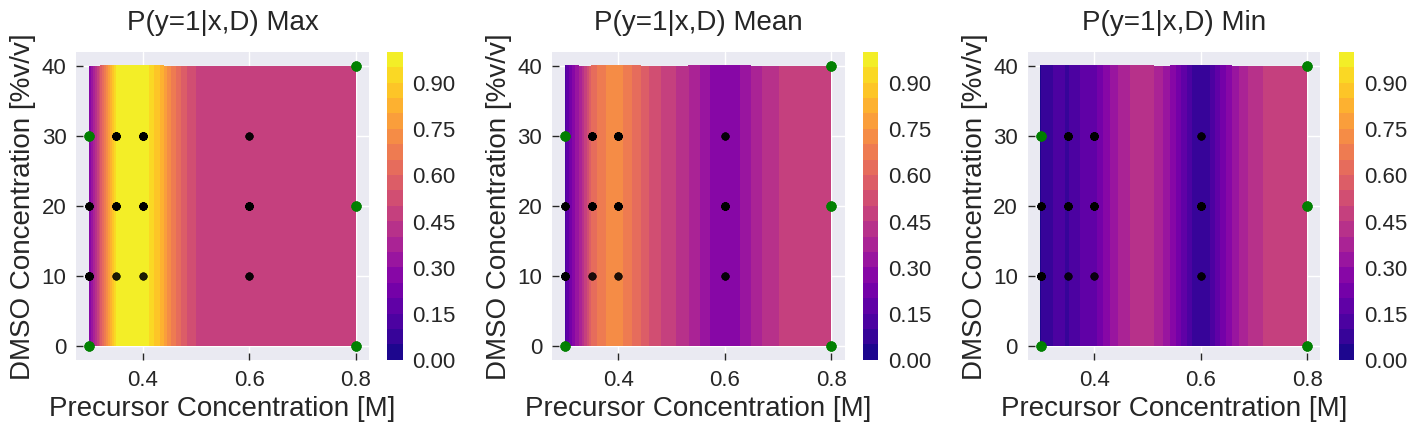

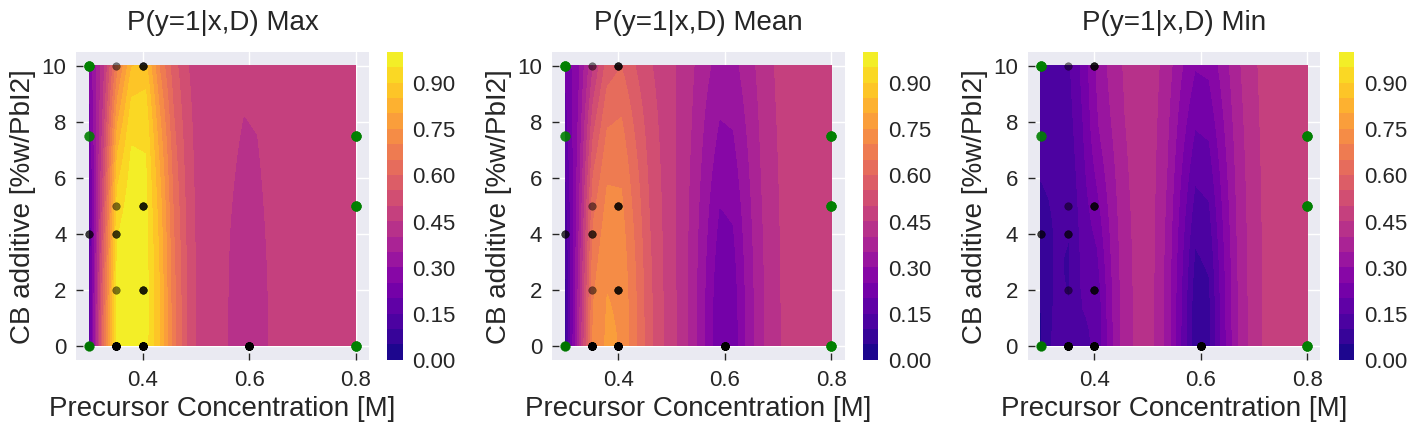

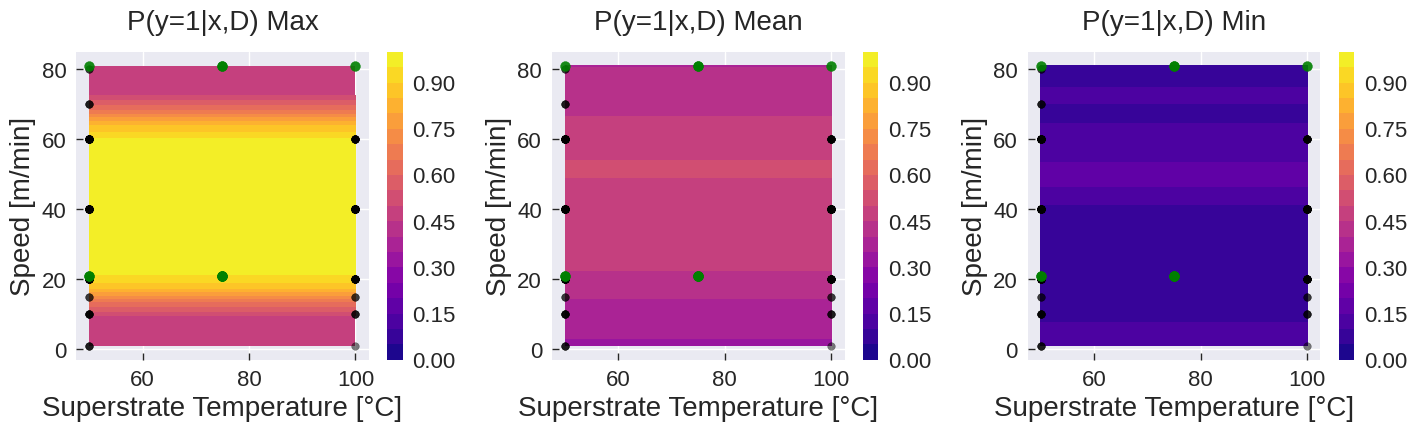

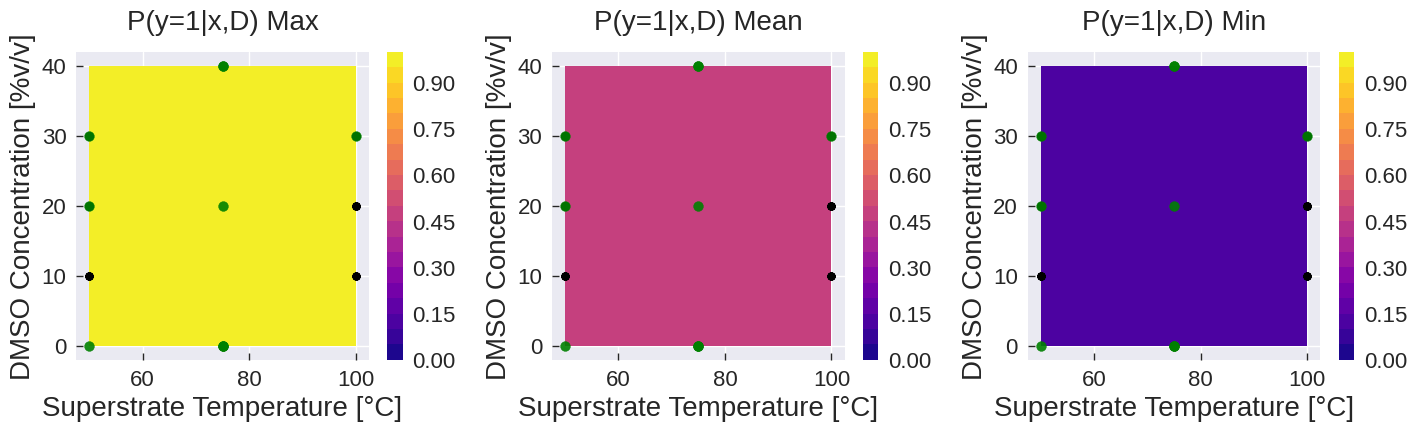

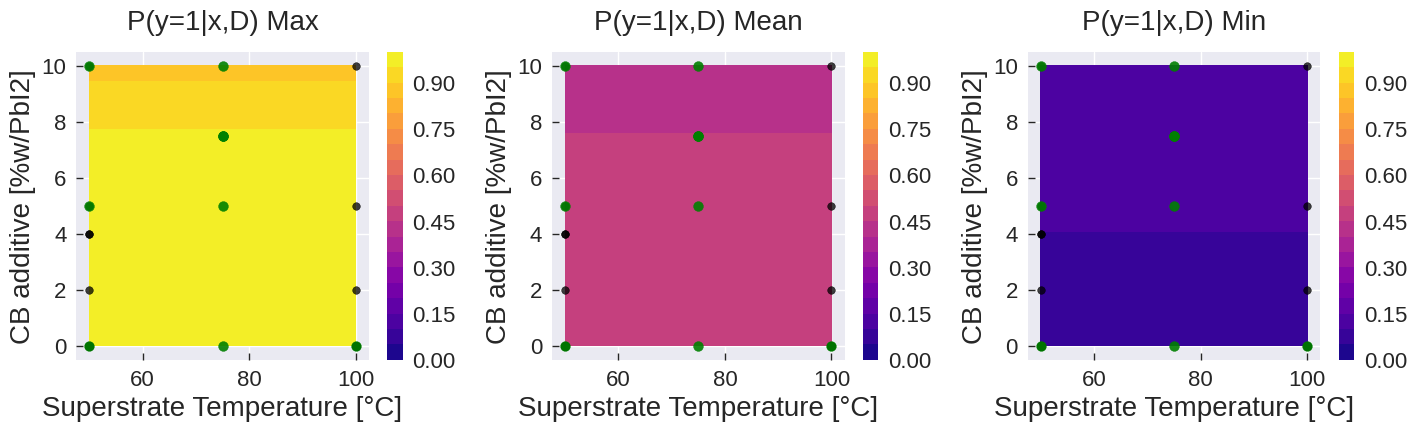

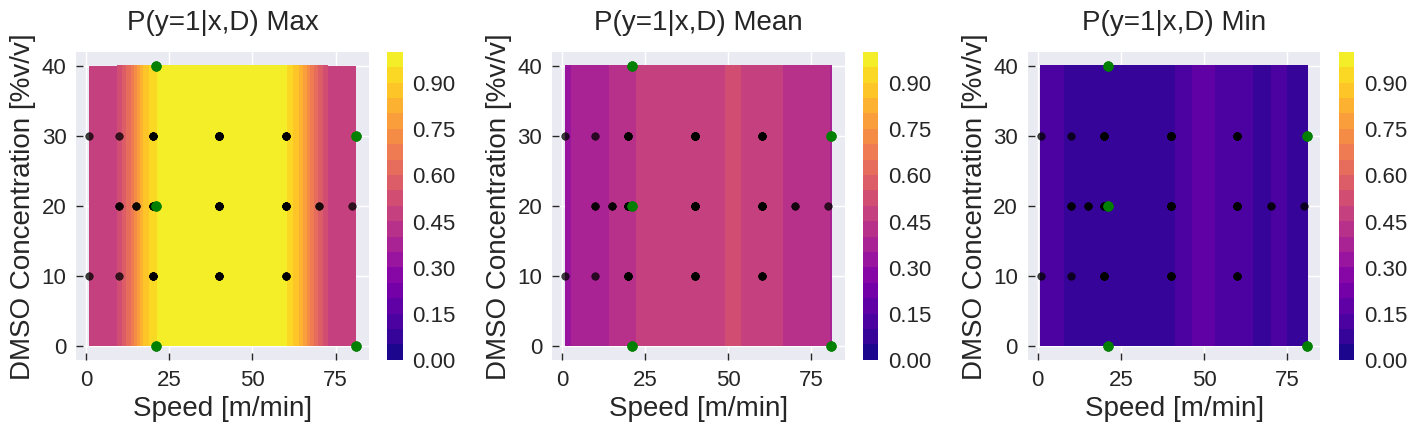

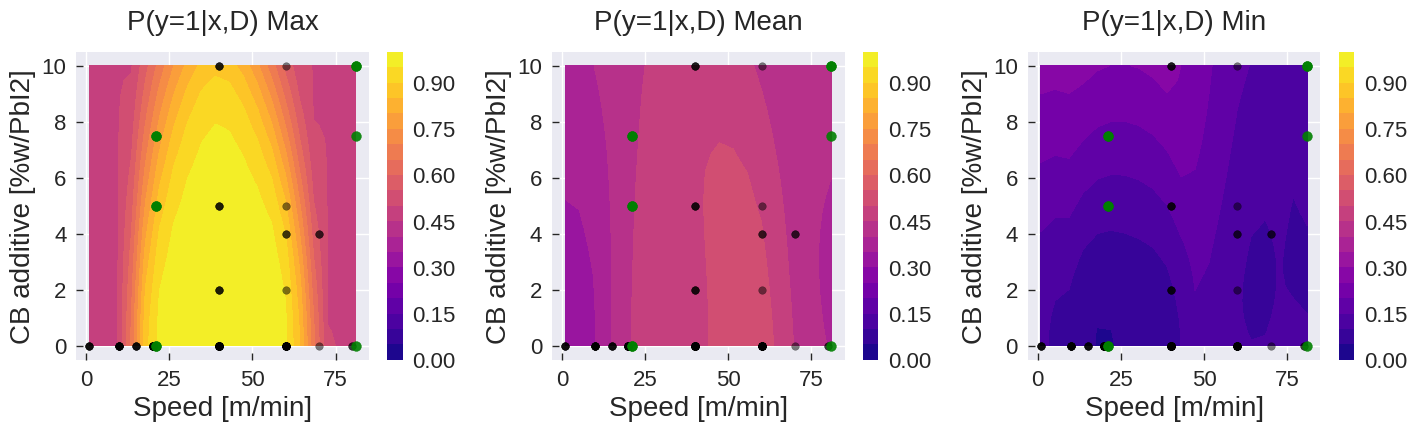

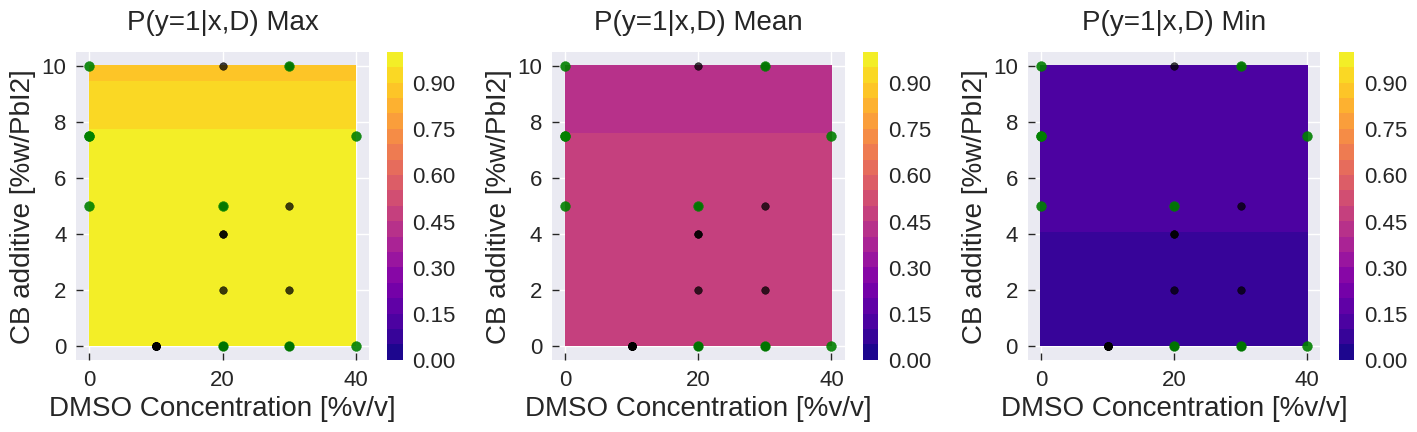

In [14]:
from emukit.core.initial_designs.random_design import RandomDesign

design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = x_labels
fontsize = 20
title_pad = 16

for i in range(input_dim):
    for j in range(input_dim - i - 1):

        ## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j + i + 1
        n_steps = 20
        x1x2y_pred, x1x2y_uncer = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2

                mu_f, var_f = objective_model.predict(x_temp)
                p_success = GPy.likelihoods.Bernoulli().gp_link.transf(mu_f / np.sqrt(1 + var_f))
                # p_success = GPy.likelihoods.Bernoulli().gp_link.transf(f_mu)

                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]

                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(p_success), np.mean(p_success), np.min(p_success)]
                )

        x1 = np.array(x1x2y_pred, dtype=float)[:, 0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=float)[:, 1].reshape(n_steps, n_steps)
        p_max = np.array(x1x2y_pred, dtype=float)[:, 2].reshape(n_steps, n_steps)
        p_mean = np.array(x1x2y_pred, dtype=float)[:, 3].reshape(n_steps, n_steps)
        p_min = np.array(x1x2y_pred, dtype=float)[:, 4].reshape(n_steps, n_steps)

        ## Contour for probability of good film
        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)

        # print(p_max, p_mean, p_min)
        for ax, y in zip(axes, [p_max, p_mean, p_min]):

            c_plt1 = ax.contourf(
                x1,
                x2,
                y,
                levels=np.linspace(0.0, 1.0, 21),
                cmap="plasma",
                # extend="both",
                # vmin=0,
                # vmax=1
            )

            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)

            # Plot current conditions
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="black",
                alpha=0.5,
                edgecolor="black",
            )

            # Plot new conditions
            ax.scatter(
                x_denormalizer(x_new_norm)[:, ind1],
                x_denormalizer(x_new_norm)[:, ind2],
                s=50,
                facecolors="green",
                alpha=0.9,
                edgecolor="green",
            )
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1) - np.min(x1)) / n_steps
            x2_delta = (np.max(x2) - np.min(x2)) / n_steps
            ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
            ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)

            # x1_delta = var_x1[1]- var_x1[0]
            # x2_delta = var_x2[1]- var_x2[0]

            # var_x1 = var_array[ind1]
            # var_x2 = var_array[ind2]

            # ax.set_xlim(np.min(var_x1) - x1_delta/n_steps, np.max(var_x1) + x1_delta/n_steps)
            # ax.set_ylim(np.min(var_x2) - x2_delta/n_steps, np.max(var_x2) + x2_delta/n_steps)

            # ax.xaxis.set_ticks(np.arange(np.min(var_x1), np.max(var_x1), x1_delta))
            # ax.yaxis.set_ticks(np.arange(np.min(var_x2), np.max(var_x2), x2_delta))

            ax.tick_params(direction="in", length=5, width=1, labelsize=fontsize * 0.8)

        axes[0].set_title("P(y=1|x,D) Max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("P(y=1|x,D) Mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("P(y=1|x,D) Min", pad=title_pad, fontsize=fontsize)

        plt.subplots_adjust(wspace=0.3)
        plt.show()

### Acquisition Functions

##### Original Acquisition Function (based on Objective Function only)

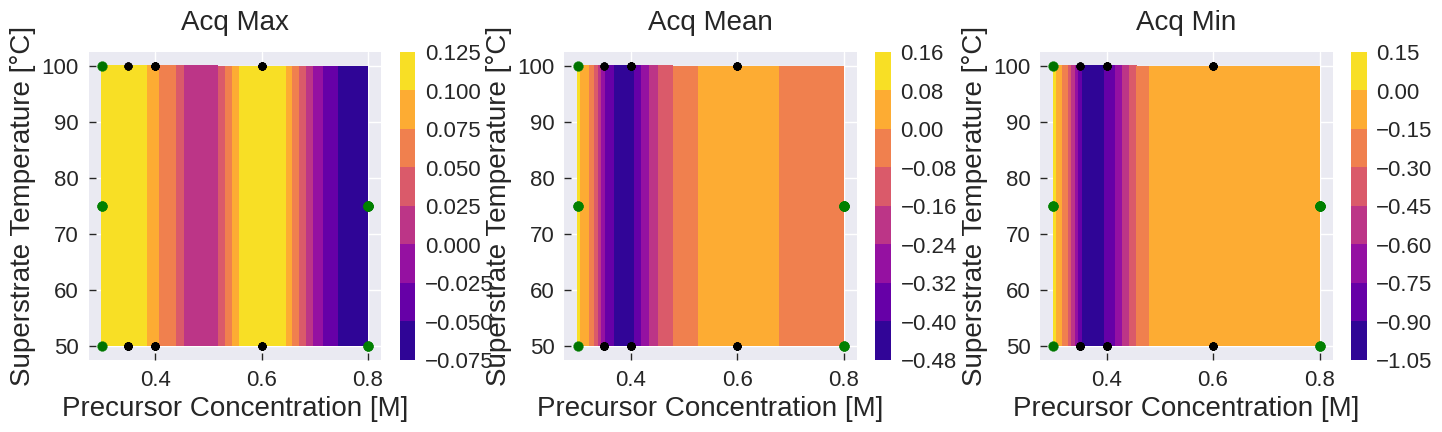

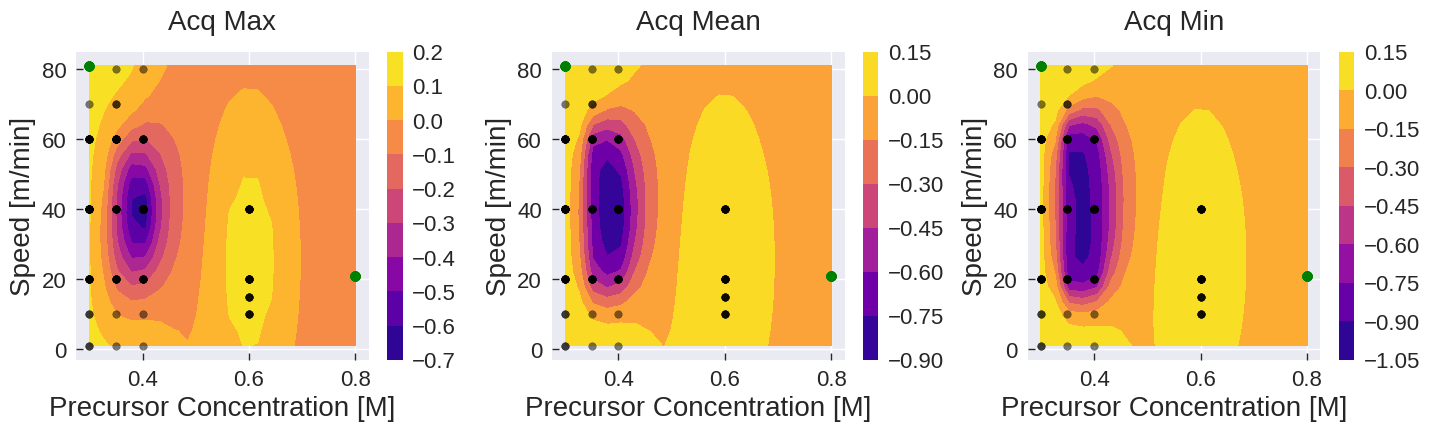

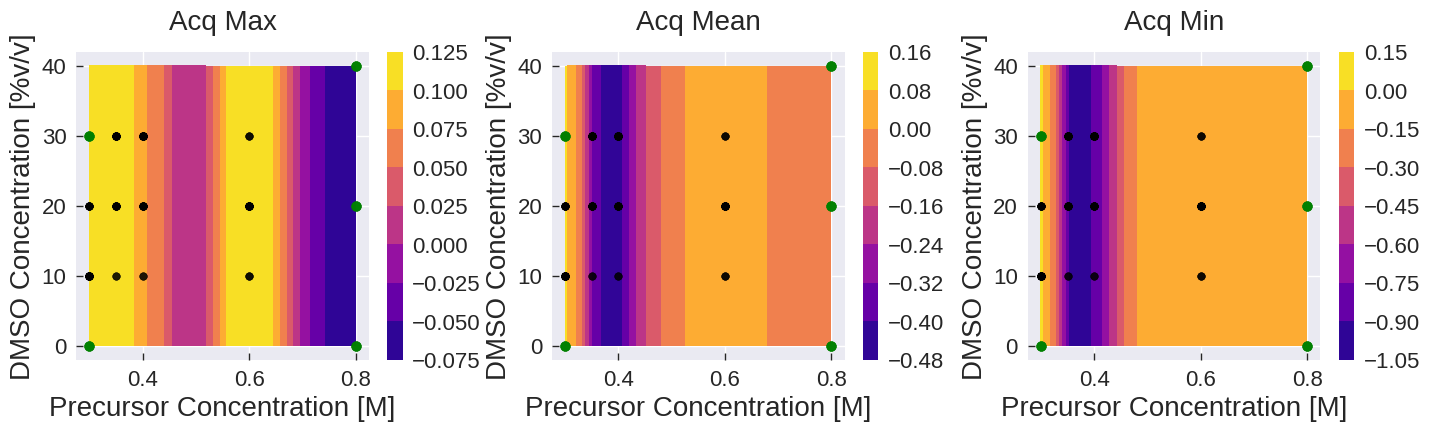

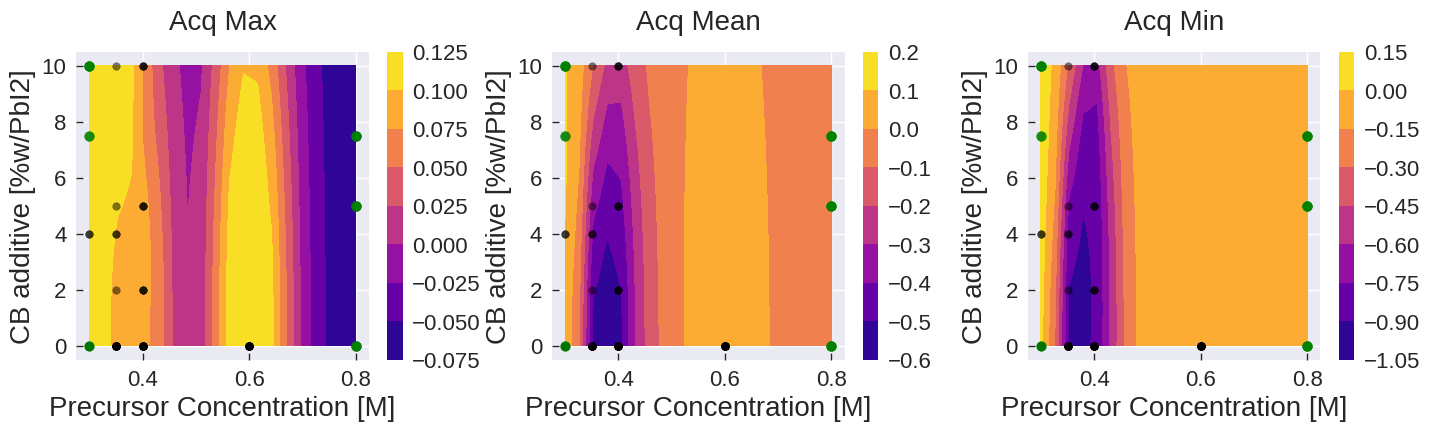

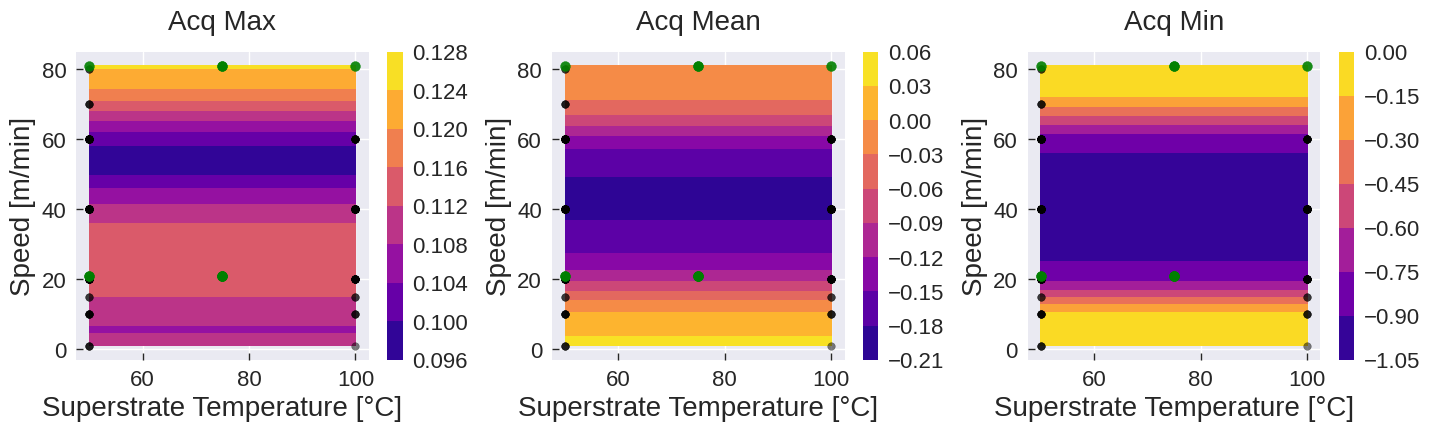

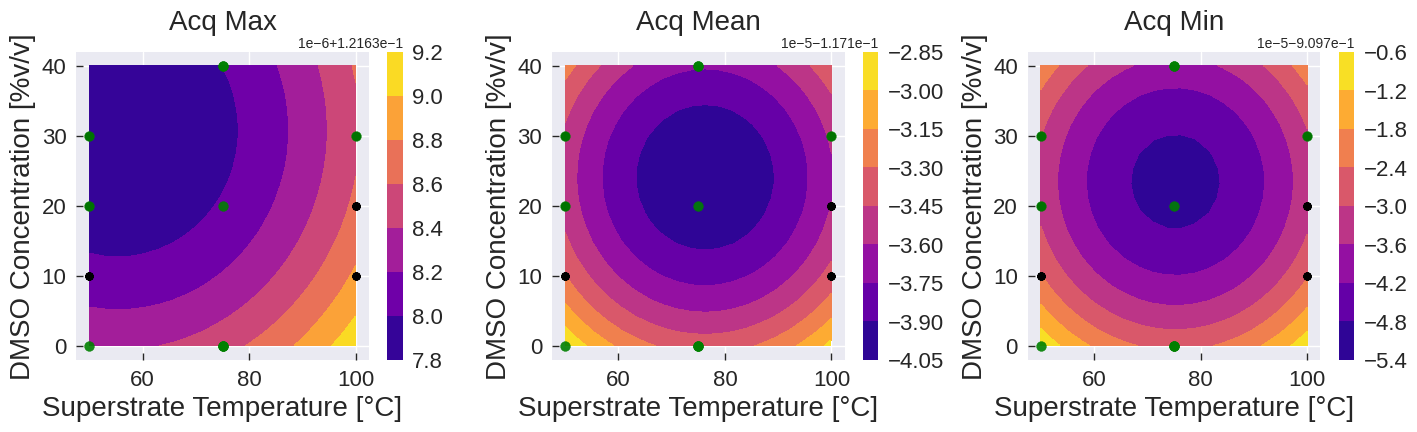

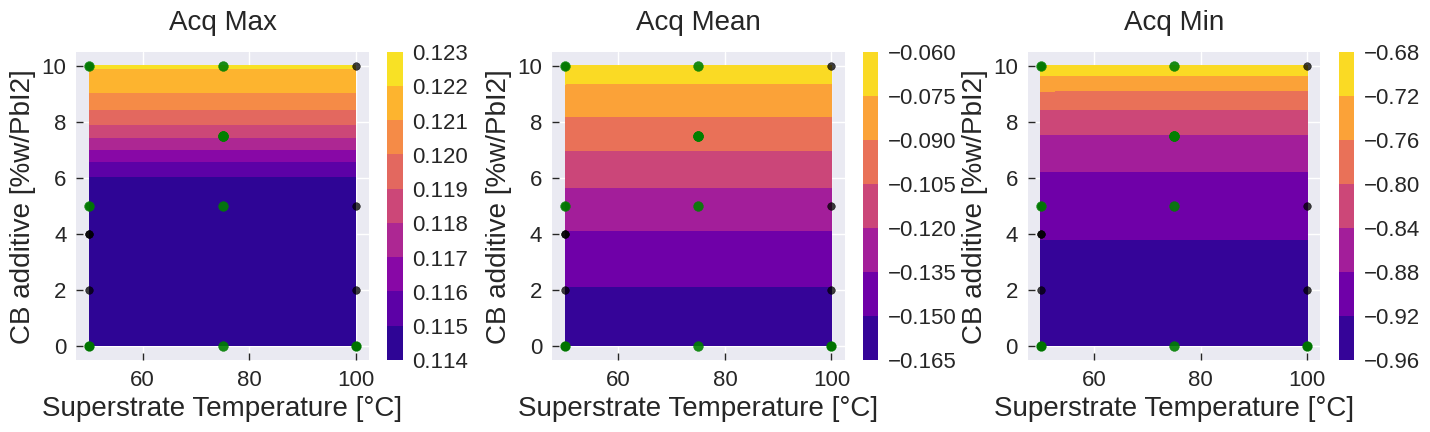

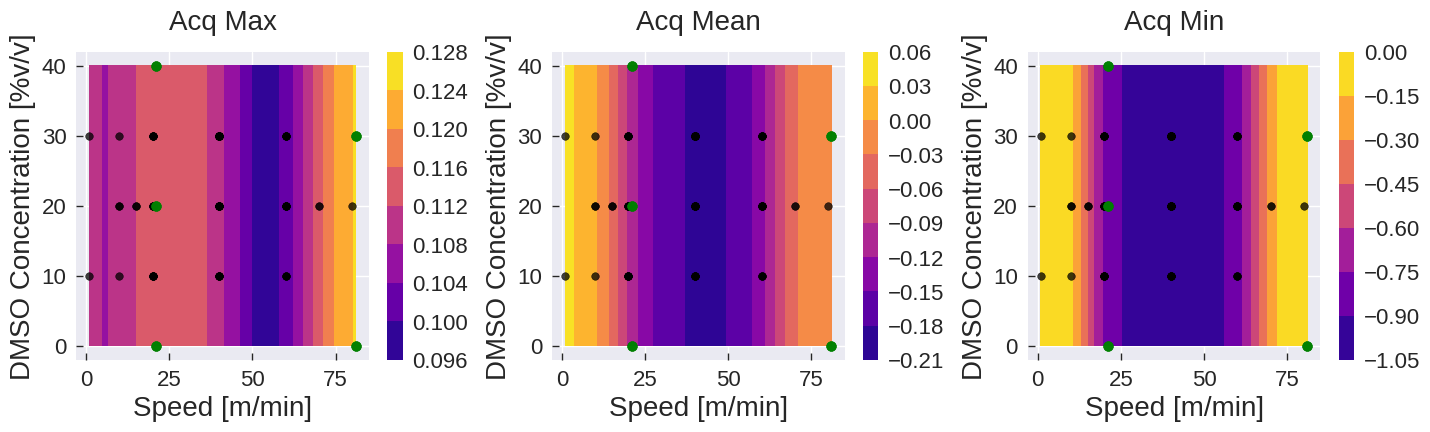

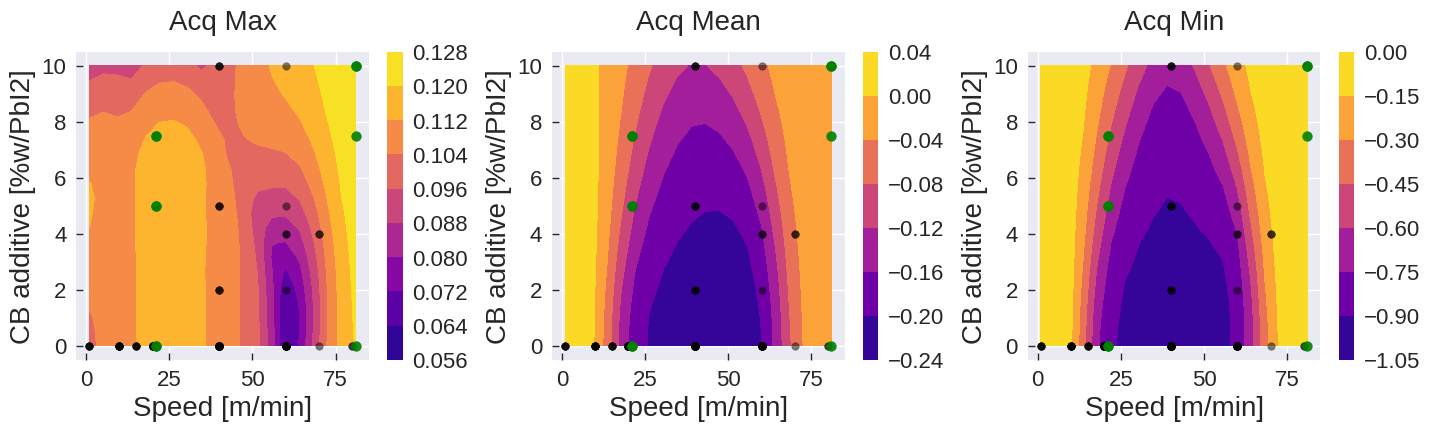

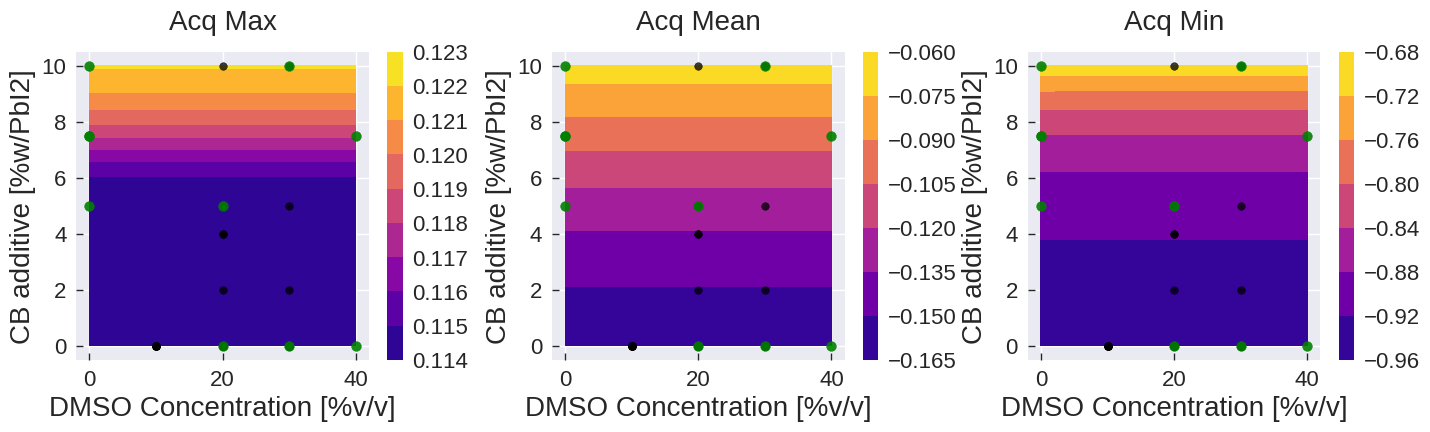

In [15]:
from emukit.core.initial_designs.random_design import RandomDesign

design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = x_labels
fontsize = 20
title_pad = 16
# prior_objective = SklearnGPModel(prior_model)

for i in range(input_dim):
    for j in range(input_dim - i - 1):

        ## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j + i + 1
        n_steps = 20
        x1x2y_pred, x1x2y_uncer = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2

                # f_mu, f_var = objective_model.predict(x_temp)
                acq_raw = acquisition_function.evaluate(x_temp)
                # p_success = GPy.likelihoods.Bernoulli().gp_link.transf(f_mu)

                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]

                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(acq_raw), np.mean(acq_raw), np.min(acq_raw)]
                )

                # print(acq_raw)

        x1 = np.array(x1x2y_pred, dtype=float)[:, 0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=float)[:, 1].reshape(n_steps, n_steps)
        p_max = np.array(x1x2y_pred, dtype=float)[:, 2].reshape(n_steps, n_steps)
        p_mean = np.array(x1x2y_pred, dtype=float)[:, 3].reshape(n_steps, n_steps)
        p_min = np.array(x1x2y_pred, dtype=float)[:, 4].reshape(n_steps, n_steps)

        ## Contour for probability of good film
        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)

        # print(p_max, p_mean, p_min)
        for ax, y in zip(axes, [p_max, p_mean, p_min]):

            c_plt1 = ax.contourf(
                x1,
                x2,
                y,
                # levels=np.linspace(0.0, 1.0, 21),
                cmap="plasma",
                # extend="both",
                # vmin=0,
                # vmax=1
            )

            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)

            # Plot current conditions
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="black",
                alpha=0.5,
                edgecolor="black",
            )

            # Plot new conditions
            ax.scatter(
                x_denormalizer(x_new_norm)[:, ind1],
                x_denormalizer(x_new_norm)[:, ind2],
                s=50,
                facecolors="green",
                alpha=0.9,
                edgecolor="green",
            )
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1) - np.min(x1)) / n_steps
            x2_delta = (np.max(x2) - np.min(x2)) / n_steps
            ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
            ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)

            # x1_delta = var_x1[1]- var_x1[0]
            # x2_delta = var_x2[1]- var_x2[0]

            # var_x1 = var_array[ind1]
            # var_x2 = var_array[ind2]

            # ax.set_xlim(np.min(var_x1) - x1_delta/n_steps, np.max(var_x1) + x1_delta/n_steps)
            # ax.set_ylim(np.min(var_x2) - x2_delta/n_steps, np.max(var_x2) + x2_delta/n_steps)

            # ax.xaxis.set_ticks(np.arange(np.min(var_x1), np.max(var_x1), x1_delta))
            # ax.yaxis.set_ticks(np.arange(np.min(var_x2), np.max(var_x2), x2_delta))

            ax.tick_params(direction="in", length=5, width=1, labelsize=fontsize * 0.8)

        axes[0].set_title("Acq Max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("Acq Mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("Acq Min", pad=title_pad, fontsize=fontsize)

        plt.subplots_adjust(wspace=0.3)
        plt.show()